In [76]:
#import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


Load and Preprocess Data

[*********************100%***********************]  1 of 1 completed


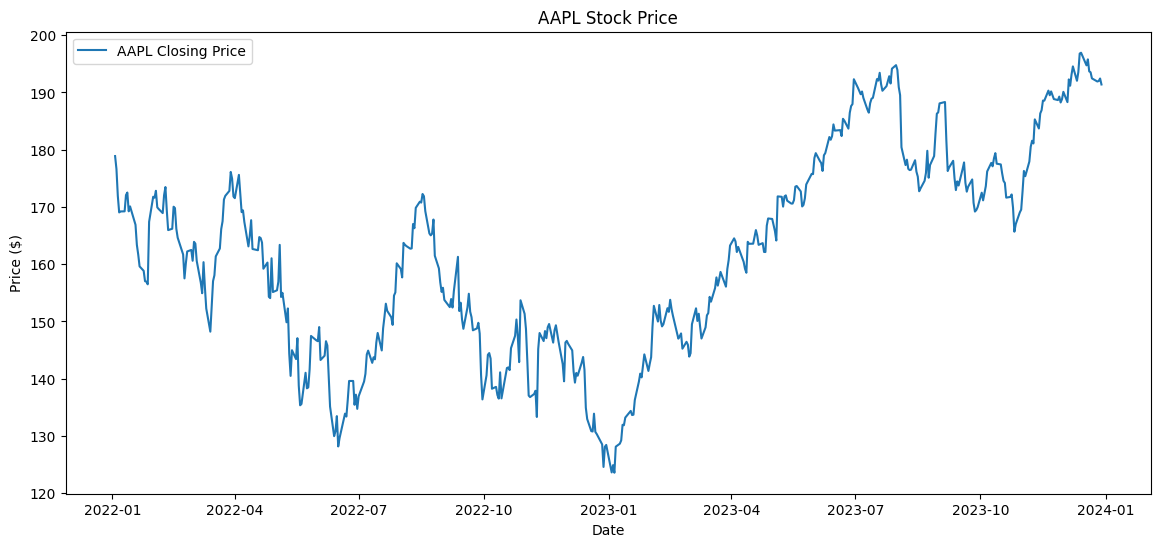

In [79]:
df = yf.download('AAPL', start='2022-01-01', end='2024-01-01')
df = df[['Close']].dropna()

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='AAPL Closing Price')
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Normalize Closing Price

In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

Create Time Series Sequences

In [81]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

Split into Train/Test

In [82]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Build LSTM Model

In [84]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

Train the model

In [85]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1187 - val_loss: 0.0070
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0131 - val_loss: 0.0306
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0083 - val_loss: 0.0125
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0

Predict and iverse Transform

In [86]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


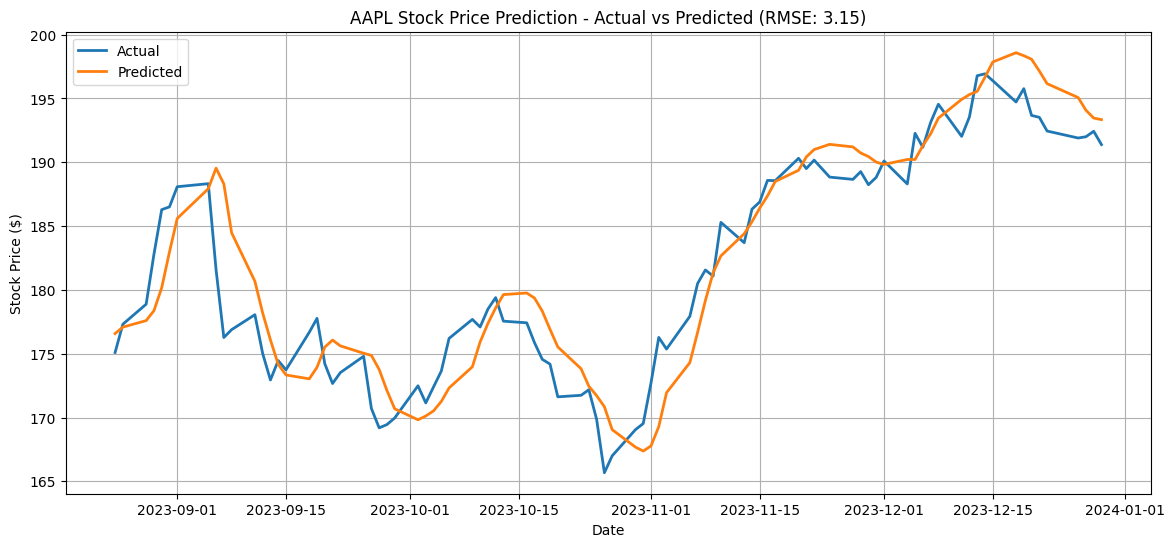

In [87]:
# Get corresponding dates
test_dates = df.index[time_step + len(y_train):]

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

plt.figure(figsize=(14, 6))
plt.plot(test_dates, actual_prices, label='Actual', linewidth=2)
plt.plot(test_dates, predicted_prices, label='Predicted', linewidth=2)
plt.title(f'AAPL Stock Price Prediction - Actual vs Predicted (RMSE: {rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid()
plt.show()